In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import keras
import nltk
from nltk.corpus import stopwords
import string
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences 
from keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout,Embedding,LSTM
from keras.layers.merge import add

In [2]:
def readtextfiles(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
captions = readtextfiles('./Flickr_Data/Flickr_TextData/Flickr8k.token.txt')
print(len(captions.split('\n')))

40461


In [4]:
captions  = captions.split('\n')[:-1]
print(captions[0])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [5]:
descriptions = {}
for x in captions:
    first,second = x.split('\t')
    img_name = first.split('.')[0]
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    descriptions[img_name].append(second)
    

In [6]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

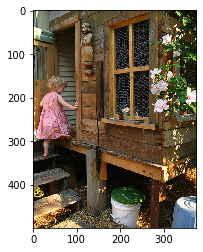

In [7]:
img_path = 'Flickr_Data/Images/'
import cv2
import matplotlib.pyplot as plt
img = cv2.imread(img_path + '1000268201_693b08cb0e.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [8]:
def cleantext(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [9]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=cleantext(caption_list[i])

In [10]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [11]:
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

In [12]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print(len(vocab))

8424


In [13]:
total_words =[]
for keys in descriptions.keys():
    [total_words.append(i) for des in descriptions[keys] for i in des.split()]
print(len(total_words))

373837


In [14]:
import collections
counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(freq_cnt)

{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [15]:
freq_cnt1 = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
threshold=10
freq_cnt1 = [x for x in freq_cnt1 if x[1]>threshold]
total_words = [x[0] for x in freq_cnt1]

In [16]:
print(len(total_words))

1845


In [17]:
test_data = readtextfiles('./Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt')
train_data = readtextfiles('./Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt')

In [18]:
train = [row.split('.')[0] for row in train_data.split('\n')[:-1]]
test = [row.split('.')[0] for row in test_data.split('\n')[:-1]]

In [20]:
train_description = {}
for img_id in train:
    train_description[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = 'startseq ' + cap + ' endseq'
        train_description[img_id].append(cap_to_append)

In [21]:
train_description['2513260012_03d33305cf']

['startseq black dog is running after white dog in the snow endseq',
 'startseq black dog chasing brown dog through snow endseq',
 'startseq two dogs chase each other across the snowy ground endseq',
 'startseq two dogs play together in the snow endseq',
 'startseq two dogs running through low lying body of water endseq']

In [16]:
model = ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 2cb95161c43110f7111970584f804107 so we will re-download the data.
102973440/102967424 [==============================] - 295s 3us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
________________________

In [28]:
new_model = Model(model.input,model.layers[-2].output)

In [31]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


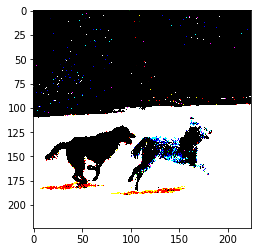

In [77]:
img = preprocess_img(img_path + '2513260012_03d33305cf.jpg')
plt.imshow(img[0])
plt.show()

In [36]:
def encode_img(img):
    img = preprocess_img(img)
    feature_vec = new_model.predict(img)
    feature_vec = feature_vec.reshape((-1,))
    #print(feature_vec.shape)
    return feature_vec

In [76]:
 encode_img(img_path + '2513260012_03d33305cf.jpg')

array([0.3470795 , 0.51159084, 0.08728848, ..., 1.1897296 , 0.04043847,
       0.1527106 ], dtype=float32)

In [38]:
start = time()
encoding_train = {}
for ix,img_id in enumerate(train):
    IMG_PATH = img_path + '/' + img_id + '.jpg'
    encoding_train[img_id] = encode_img(IMG_PATH)
    
    if ix%100 == 0:
        print("Encoding time step %d"%ix)
end_t = time()
print("total time",end_t - start)

Encoding time step 0
Encoding time step 100
Encoding time step 200
Encoding time step 300
Encoding time step 400
Encoding time step 500
Encoding time step 600
Encoding time step 700
Encoding time step 800
Encoding time step 900
Encoding time step 1000
Encoding time step 1100
Encoding time step 1200
Encoding time step 1300
Encoding time step 1400
Encoding time step 1500
Encoding time step 1600
Encoding time step 1700
Encoding time step 1800
Encoding time step 1900
Encoding time step 2000
Encoding time step 2100
Encoding time step 2200
Encoding time step 2300
Encoding time step 2400
Encoding time step 2500
Encoding time step 2600
Encoding time step 2700
Encoding time step 2800
Encoding time step 2900
Encoding time step 3000
Encoding time step 3100
Encoding time step 3200
Encoding time step 3300
Encoding time step 3400
Encoding time step 3500
Encoding time step 3600
Encoding time step 3700
Encoding time step 3800
Encoding time step 3900
Encoding time step 4000
Encoding time step 4100
Enco

In [40]:
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [83]:
IMG_PATH =  '2513260012_03d33305cf' + '.jpg'
print(IMG_PATH)

2513260012_03d33305cf.jpg


In [82]:
encoding_train['2513260012_03d33305cf.jpg']

KeyError: '2513260012_03d33305cf.jpg'

In [41]:
start = time()
encoding_test = {}
for ix,img_id in enumerate(test):
    IMG_PATH = img_path + '/' + img_id + '.jpg'
    encoding_test[img_id] = encode_img(IMG_PATH)
    
    if ix%100 == 0:
        print("Encoding time step %d"%ix)
end_t = time()
print("total time",end_t - start)

Encoding time step 0
Encoding time step 100
Encoding time step 200
Encoding time step 300
Encoding time step 400
Encoding time step 500
Encoding time step 600
Encoding time step 700
Encoding time step 800
Encoding time step 900
total time 165.38571858406067


In [42]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [22]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word

In [23]:
word_to_idx['dog']
idx_to_word[6]

'dog'

In [24]:
word_to_idx['startseq']=1846
idx_to_word[1846]='startseq'
word_to_idx['endseq']=1847
idx_to_word[1847]='endseq'
vocab_size = len(word_to_idx)+1
print(vocab_size)

1848


In [25]:
with open("i2w.pkl","wb") as f:
    pickle.dump(idx_to_word,f)
with open("w2i.pkl","wb") as f:
    pickle.dump(word_to_idx,f)

In [50]:
max_len=0
for key in train_description.keys():
    for cap in train_description[key]:
        max_len = max(max_len,len(cap.split()))
print(max_len)

35


In [89]:
def data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y = [],[],[]
    n =0;
    while True:
        for key,cap_list in train_description.items():
            n+=1
            photo = encoding_train[key]
            for desc in cap_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes = vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                if n==batch_size:
                    yield[np.array(X1),np.array(X2)],np.array(y)
                    X1,X2,y = [],[],[]
                    n=0
            

In [54]:
f = open("./glove.6B.50d.txt",encoding='utf8')

In [57]:
embedding_matrix={}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_matrix[word] = word_embedding

In [58]:
f.close()
embedding_matrix['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [59]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector =  embedding_matrix.get(word)
        
        if embedding_vector is not None:
            matrix[idx]= embedding_vector
            
    return matrix

In [60]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [61]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [62]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [63]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

model = Model(inputs=[input_img_features,input_captions],outputs=outputs)


In [64]:
model.summary()

Model: "functional_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

In [65]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [100]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [72]:
epochs = 20
batch_size = 3
steps = len(train_description)//batch_size

In [98]:
def train():
    for i in range(epochs):
        generator = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [101]:
model = load_model('./model_weights/model_9.h5')

In [102]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

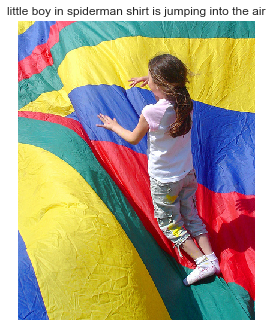

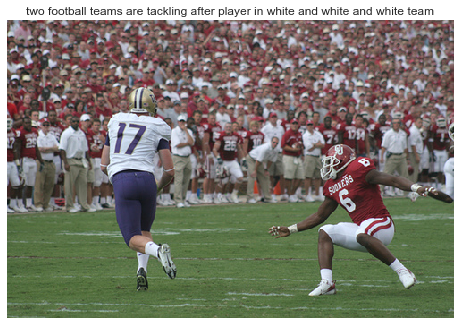

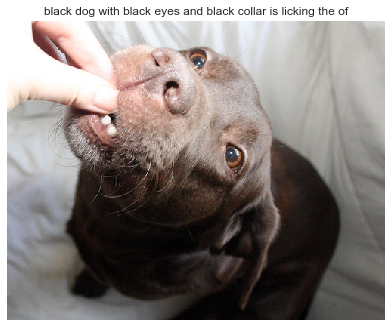

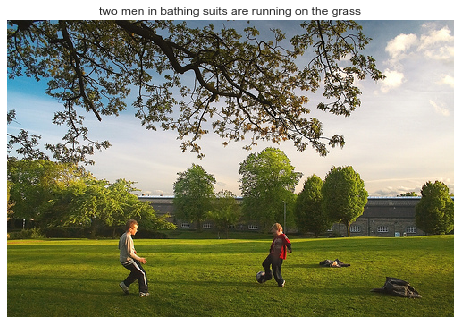

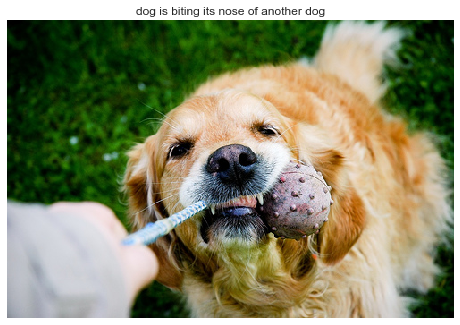

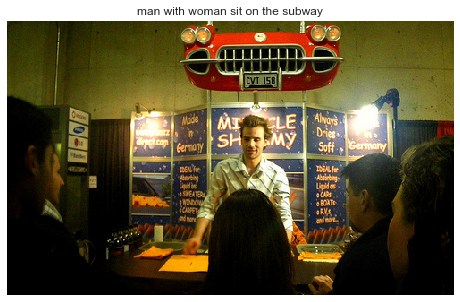

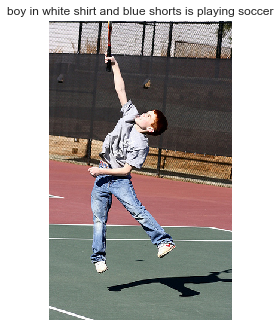

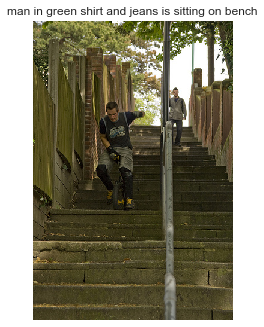

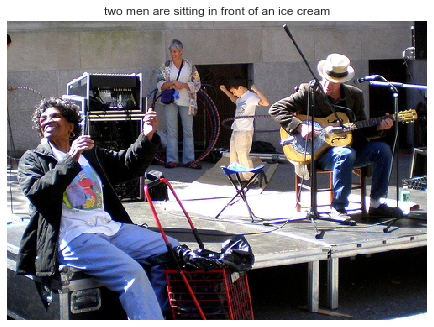

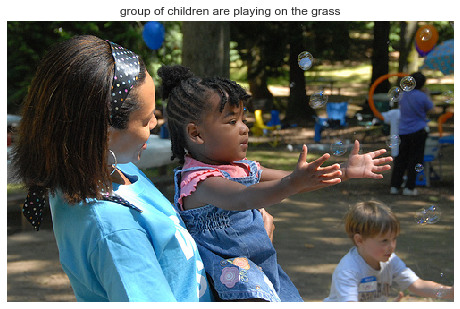

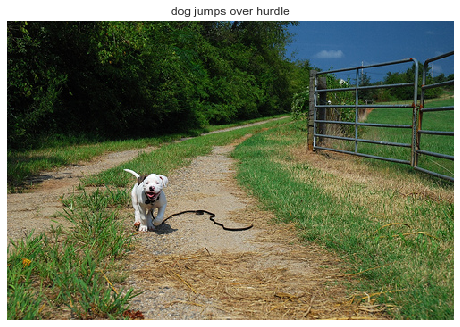

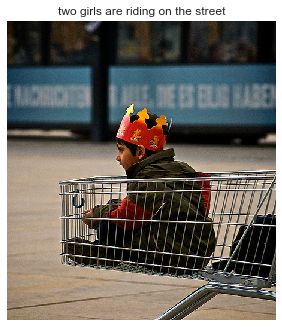

In [104]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread(img_path+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()